# Bolivian League Betting Odds

In [30]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.ticker as ticker
import re
from collections import Counter
style.use('fivethirtyeight')


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [31]:
# Reading and appending datasets
odds_16_08 = pd.read_csv('odds_portal_2016_2008.csv', parse_dates= ['date'] )
odds_17 = pd.read_csv('odds_portal_2017.csv', parse_dates= ['date'])
odds_18 = pd.read_csv('odds_portal_2018.csv', parse_dates= ['date'])
odds_19 = pd.read_csv('odds_portal_2019.csv', parse_dates= ['date'])

odds = odds_16_08.append([odds_17, odds_18, odds_19])



In [32]:
odds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24759 entries, 0 to 3740
Data columns (total 12 columns):
web-scraper-order        24759 non-null object
web-scraper-start-url    24759 non-null object
match                    24759 non-null object
match-href               24759 non-null object
Bookmakers               21802 non-null object
Home Odds                21802 non-null float64
Draw Odds                21802 non-null float64
Away Odds                21802 non-null float64
Payout                   21802 non-null object
results                  24759 non-null object
date                     24758 non-null datetime64[ns]
time                     24758 non-null object
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 2.5+ MB


### Cleaning the dataframe


In [60]:
# Making column names easier to work with
odds.columns = [c.lower().replace("-", "_") for c in [i.replace(" ", "-") for i in odds.columns]]
odds.columns

# Creating new columns 

# Teams
odds['home_team'] = [i[0].strip() for i in odds.match.str.split("-")]
odds['away_team'] = [i[1].strip() for i in odds.match.str.split("-")]

# Final Results
odds['final_result'] = [c[0:3] for c in [i.replace('Final result ', '') for i in odds.results]]
odds['home_final_result'] = [i[0] for i in odds.final_result.str.split(':')]
odds['away_final_result'] = [i[-1] for i in odds.final_result.str.split(':')]

# Half times results
odds['halftime'] = odds.results.str.extract(r"\((.*?)\)", expand=False).str.split(',')

odds.dropna(subset=['halftime'],inplace=True) # dropping rows that don't have half time info

odds['first_half_home'] = [c[0] for c in [i[0] for i in odds.halftime]]
odds['first_half_away'] = [c[2] for c in [i[0] for i in odds.halftime]]
odds['second_half_home'] = [c[0] for c in [i[1].strip() for i in odds.halftime]]
odds['second_half_away'] = [c[2] for c in [i[1].strip() for i in odds.halftime]]

# Fixing unique cases in score
odds.home_final_result[odds.home_final_result=='Wil'] = 7
odds.away_final_result[odds.away_final_result=='Wil'] = 0

# Dropping columns
odds.drop(['halftime','web_scraper_start_url','web_scraper_order'], axis=1, inplace=True)


Index(['web_scraper_order', 'web_scraper_start_url', 'match', 'match_href',
       'bookmakers', 'home_odds', 'draw_odds', 'away_odds', 'payout',
       'results', 'date', 'time', 'home_team', 'away_team', 'final_result',
       'home_final_result', 'away_final_result', 'first_half_home',
       'first_half_away', 'second_half_home', 'second_half_away',
       'total_goals'],
      dtype='object')

/Users/miketondu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/miketondu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Feature Engineering

In [74]:
# Creating new features
# Transforming values into numeric type
for col in odds.columns[odds.columns!='date']:
    odds[col] = pd.to_numeric(odds[col], errors='ignore')

# Total number of goals
odds['total_goals'] = odds.home_final_result + odds.away_final_result

# First half goals
odds['total_first_half'] = odds.first_half_home + odds.first_half_away

# Second half goals
odds['total_second_half'] = odds.second_half_home + odds.second_half_away

# Penalties
odds.results[odds.results.str.contains('penalties')]


580      Final result 2:0 penalties (0:0, 1:0, 5:4)
706      Final result 2:1 penalties (1:1, 0:0, 6:5)
1056     Final result 3:1 penalties (1:1, 1:0, 4:3)
1617     Final result 1:2 penalties (1:1, 0:0, 3:4)
1765     Final result 2:0 penalties (0:0, 1:0, 5:4)
3710     Final result 1:2 penalties (1:1, 0:0, 3:4)
3874     Final result 1:2 penalties (0:0, 1:1, 1:3)
4634     Final result 1:2 penalties (0:0, 1:1, 1:3)
4804     Final result 2:0 penalties (0:0, 1:0, 5:4)
4880     Final result 3:2 penalties (1:1, 1:1, 4:2)
4969     Final result 1:2 penalties (1:1, 0:0, 3:4)
5719     Final result 3:1 penalties (1:1, 1:0, 4:3)
7204     Final result 1:2 penalties (1:1, 0:0, 3:4)
7813     Final result 2:0 penalties (0:0, 1:0, 5:4)
8133     Final result 3:2 penalties (1:1, 1:1, 4:2)
8213     Final result 3:1 penalties (1:1, 1:0, 4:3)
8432     Final result 3:1 penalties (1:1, 1:0, 4:3)
9003     Final result 1:2 penalties (0:0, 1:1, 1:3)
9008     Final result 3:2 penalties (1:1, 1:1, 4:2)
9888     Fin

In [75]:
odds.head()


,match,match_href,bookmakers,home_odds,draw_odds,away_odds,payout,results,date,time,home_team,away_team,final_result,home_final_result,away_final_result,first_half_home,first_half_away,second_half_home,second_half_away,total_goals,total_first_half,total_second_half
0,Blooming - San Jose,https://www.oddsportal.com/soccer/bolivia/liga...,Unibet,2.29,3.15,2.80,90.0%,"Final result 0:0 (0:0, 0:0)",2013-08-04,00:00,Blooming,San Jose,0:0,0,0,0,0,0,0,0,0,0
1,The Strongest - Ciclon,https://www.oddsportal.com/soccer/bolivia/liga...,Unibet,1.25,5.25,9.00,90.8%,"Final result 4:2 (2:0, 2:2)",2016-04-17,19:00,The Strongest,Ciclon,4:2,4,2,2,0,2,2,6,2,4
2,Blooming - Real Potosi,https://www.oddsportal.com/soccer/bolivia/liga...,bwin,1.70,3.40,4.33,89.8%,"Final result 2:0 (1:0, 1:0)",2014-04-12,21:00,Blooming,Real Potosi,2:0,2,0,1,0,1,0,2,1,1
4,The Strongest - Guabira,https://www.oddsportal.com/soccer/bolivia/liga...,Unibet,1.55,3.50,5.50,89.9%,"Final result 2:1 (1:1, 1:0)",2010-03-31,22:00,The Strongest,Guabira,2:1,2,1,1,1,1,0,3,2,1
5,Blooming - Oriente Petrolero,https://www.oddsportal.com/soccer/bolivia/liga...,bwin,2.40,3.10,2.70,90.1%,"Final result 2:2 (2:2, 0:0)",2012-04-29,22:30,Blooming,Oriente Petrolero,2:2,2,2,2,2,0,0,4,4,0


In [76]:
odds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24221 entries, 0 to 3740
Data columns (total 22 columns):
match                24221 non-null object
match_href           24221 non-null object
bookmakers           21389 non-null object
home_odds            21389 non-null float64
draw_odds            21389 non-null float64
away_odds            21389 non-null float64
payout               21389 non-null object
results              24221 non-null object
date                 24220 non-null datetime64[ns]
time                 24220 non-null object
home_team            24221 non-null object
away_team            24221 non-null object
final_result         24221 non-null object
home_final_result    24221 non-null int64
away_final_result    24221 non-null int64
first_half_home      24221 non-null int64
first_half_away      24221 non-null int64
second_half_home     24221 non-null int64
second_half_away     24221 non-null int64
total_goals          24221 non-null int64
total_first_half     24221 n

In [17]:
odds.home_final_result.value_counts()

1    6975
2    6386
3    3778
0    3702
4    1924
5     817
6     441
7     127
9      31
8      29
7      11
Name: home_final_result, dtype: int64

### Plotting Trends

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([736726., 736785., 736846., 736907., 736968., 737029., 737091.,
        737150., 737211., 737272., 737333.]),
 <a list of 11 Text xticklabel objects>)

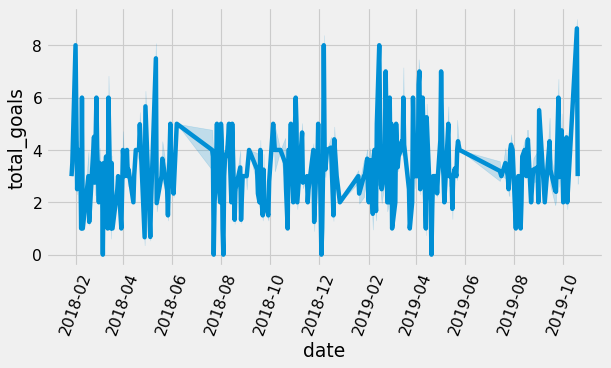

In [58]:
fig, axes = plt.subplots( figsize=(8,4), dpi=80)

sns.lineplot(data= odds, x=odds.date[odds['date']>'2018'], y=odds.total_goals[odds['date']>'2018'])
plt.xticks(rotation=70)